# Vehicle Detection
### by Kilian Muelken

---
#### Code Cell 1: necessary imports for the code

In [1]:
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.externals import joblib
import copy
from scipy.ndimage.measurements import label

___
## Part 1: Vehicle detection functions
*Functions for the vehicle Detection*

### Part 1.1: Common functions

___
#### Code Cell ?: Calculate sliding windows
**Input:** image, start and stop positions in both x and y, window size (x and y dimensions),  and overlap fraction (for both x and y)<br>
**Output:** List of sliding windows

In [2]:
def calcSlideWindows(img):
    x_start = 0
    x_stop = img.shape[1]
    y_start = int(img.shape[0] * 0.5) # should be the highest place in the image, where cars can be seen
    y_stop = img.shape[0] * 1 # above the bonnet
    xy_window=(64, 64)
    xy_overlap=(0.5, 0.5)
        
    # Compute the span of the region to be searched    
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    slidingWindows = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start
            endy = starty + xy_window[1]
            
            # Append window position to list
            slidingWindows.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return slidingWindows

___
#### Code Cell ?: Plot and save images
**Input:** list of images<br>
**Output:** plots and saves images

In [3]:
def plotImage(imgs, save=False):
    # check if imgs is a list
    imglist = []
    
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist.append(imgs)
        
    n_img = len(imglist)
    
    plt.figure(figsize=(20,5))
    
    for i in range(n_img):
        # plot image
        n_plot = 101 + n_img*10 + i
        plt.subplot(n_plot) # source: https://stackoverflow.com/questions/35692507/plot-several-image-files-in-matplotlib-subplots
        plt.imshow(imglist[i])
        
        # save image if save=true
        if save:
            #img_BGR = cv2.cvtColor(img_list[i],cv2.COLOR_RGB2BGR)
            img_name = 'image_'+time.strftime('%m_%Y_%H_%M_%S')+'.jpg'
            mpimg.imsave('output_images/'+img_name, imglist[i])

___
#### Code Cell ?: Draw bounding boxes
**Input:** image to draw the boxes, position and size of the boxes<br>
**Output:** image with boxes drawn

In [4]:
def drawBoxes(img, bboxes):
    color = (0, 0, 255) # Color of the boxes is blue
    thick = 6  # thickness of the boxes
    
    img_boxes = np.copy(img) # Make a copy of the image
    
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(img_boxes, bbox[0], bbox[1], color, thick) # Draw a rectangle given bbox coordinates
    
    return img_boxes # return the image with boxes drawn

#### Code Cell ?: Read test images
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [5]:
def readImages(path):
    images = []
    images_list = glob.glob(path) # Make a list of calibration images

    # Step through the list, read test images and convert them to RGB
    for fname in images_list:
        img = cv2.imread(fname)
        rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(rgb)
    return images

___
#### Code Cell ?: Search for positive matches in windows
*Uses extractFeatures()*
**Input:** Image, Silde windows, Classifier, Scaler<br>
**Output:** positive matches in windows

In [6]:
def searchPositiveWindows(img, windows, clf, scaler):
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        features = extractFeatures(test_img)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # Return windows for positive detections
    return on_windows

___
#### Code Cell ?: Check if windows are overlapping
**Input:** 2 Windows<br>
**Output:** Boolean (True if they are overlapping)

In [7]:
# check if windows overlap
def overlapWindow(win1, win2):
    x_left_w1 = win1[0][0] # x positition of the left upper point of the first window
    y_top_w1 = win1[0][1] # y positition of the left upper point of the first window
    x_right_w1 = win1[1][0] # x positition of the right bottom point of the first window
    y_bottom_w1 = win1[1][1] # y positition of the right bottom point of the first window
    
    x_left_w2 = win2[0][0] # x positition of the left upper point of the second window
    y_top_w2 = win2[0][1] # y positition of the left upper point of the second window
    x_right_w2 = win2[1][0] # x positition of the right bottom point of the second window
    y_bottom_w2 = win2[1][1] # y positition of the right bottom point of the second window
    
    # if left upper point of the first window is in the second window
    if ( (x_left_w2 <= x_left_w1 <= x_right_w2) & (y_top_w2 <= y_top_w1 <= y_bottom_w2) ):
        overlap = True
            
    # if right upper point of the first window is in second window
    elif ( (x_left_w2 <= x_right_w1 <= x_right_w2) & (y_top_w2 <= y_top_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if left bottom point of the first window is in second window
    elif ( (x_left_w2 <= x_left_w1 <= x_right_w2) & (y_top_w2 <= y_bottom_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if right bottom point of the first window is in second window
    elif ( (x_left_w2 <= x_right_w1 <= x_right_w2) & (y_top_w2 <= y_bottom_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if there is no overlapping
    else:
        overlap = False
    
    return overlap

___
#### Code Cell ?: Find and eliminate false positive windows
**Input:** Detected windows with cars<br>
**Output:** Windows with eliminated false positives

In [8]:
def falsePositives(windows, last_windows):
    
    # Create an empty list to receive positive detection windows
    windows_eliminated = []
    
    # Iterate over all windows in the list
    for window in windows:        
        for last_window in last_windows:            
            if overlapWindow(window, last_window):
                windows_eliminated.append(window)
    
    return windows_eliminated

___
#### Code Cell ?: Find and merge mulitple detections
**Input:** Detected windows with cars<br>
**Output:** windows with merged multiple detections

In [9]:
def multipleDetectionsOld(windows):
    
    #### 1. seperate all windows in different window groups and put overlapping windows in the same group
    window_groups = []
    
    #### 1.1 allocate windows to window groups
    for window1o in windows: # take a window from the list
        window1 = copy.copy(window1o)
        firstmatch = True # is true for the first match
        
        # 1.1.1 check if the window overlaps with a window in the window groups
        for win_group in window_groups: # go through exisiting window groups
            for window2 in win_group: # go through windows in the window group
                if overlapWindow(window1, window2): # check if the first window overlaps with a window
                    
                    # copy window group and append current window
                    if firstmatch: 
                        window_group = copy.deepcopy(win_group) # copy this group
                        window_groups.remove(win_group) # remove the group from the lsit of window groups
                        window_group.append(window1) # append the window to the window group
                        windows.remove(window1o) # remove current window from window list, because it is in a window group
                        firstmatch = False
                        
                    # if there are more matches, merge both window groups
                    else:
                        for window3 in win_group:
                            if window3 not in window_group:
                                window_group.append(window3)
                        
                        if win_group in window_groups:
                            window_groups.remove(win_group) # remove the group from the lsit of window groups
        
        # 1.1.2 if there is no overlap with a window of a existing group          
        if firstmatch:
            window_group = [] # make a new group
            window_group.append(window1) # append current window to group
            windows.remove(window1o) # delete current window from window list, because it is in a window group
        
        # append window group to list of window groups
        window_groups.append(window_group)


    #### 2. calculate the total windows for each group ##################################################
    windows_multiDetect = []
    print(window_groups)
    for win_group in window_groups:
        xul = min(win[0][0] for win in win_group)
        yul = min(win[0][1] for win in win_group)
        xbr = max(win[1][0] for win in win_group)
        ybr = max(win[1][1] for win in win_group)
                
        total_window = ((xul, yul), (xbr, ybr))
        windows_multiDetect.append(total_window)
    
    return windows_multiDetect

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def getbboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        bboxes.append(bbox)

    # Return the bboxes
    return bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
        
def multipleDetections(image, windows):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    bboxes = getbboxes(labels)
    final_img = drawBoxes(image, bboxes)
    
    return final_img
    

___
### Part 1.2: Feature functions

___
#### Code Cell ?: Compute HOG features
**Input:** Image<br>
**Output:** HOG features

In [11]:
def hogFeatures(img):
    orientations = 9
    pix_per_cell = 8
    pixels_per_cell=(pix_per_cell, pix_per_cell)
    cell_per_block = 2
    cells_per_block=(cell_per_block, cell_per_block)
    block_norm = 'L2-Hys'
    transform_sqrt = True
    visualise = False
    feature_vector = True
    hog_channel = 0
    
    
    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features_channel = hog(img[:,:,channel], orientations=orientations, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=visualise, feature_vector=feature_vector)
            
            hog_features.append(hog_features_channel)
        features = np.ravel(hog_features)        
    else:
        img_hog = img[:,:,hog_channel]
        features = hog(img_hog, orientations=orientations, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), 
                    block_norm= 'L2-Hys',
                    transform_sqrt=True, 
                    visualise=visualise, feature_vector=feature_vector)
    return features

___
#### Code Cell ?: Compute binned color features 
**Input:** Image<br>
**Output:** binned color features

In [12]:
def binSpatial(img):
    size=(32, 32)
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

___
#### Code Cell ?: Compute color histogram features 
**Input:** Image<br>
**Output:** binned color features

In [13]:
def colorHist(img):
    nbins=32
    bins_range=(0, 256) # NEED TO CHANGE bins_range if reading .png files with mpimg!
        
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return features

___
#### Code Cell ?: Extract features 
*Uses hogFeatures(), binSpatial() and colorHist()*
**Input:** Image<br>
**Output:** features

In [14]:
def extractFeatures(imgs):
    color_space = 'RGB'
    spatial_feat = True
    hist_feat  =True
    hog_feat = True
    hog_channel = 0
    
    # check if imgs is a list
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist = []
        imglist.append(imgs)
        
    # Create a list to append feature vectors to
    features = []
    
    for img in imglist:
        img_features = []
    
        # color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img) 

        # Compute binned color features
        if spatial_feat == True:
            spatial_features = binSpatial(feature_image)
            img_features.append(spatial_features)
            

        # Compute color histogram features
        if hist_feat == True:
            hist_features = colorHist(feature_image)
            img_features.append(hist_features)
            

        # Compute HOG features
        if hog_feat == True:
            hog_features = hogFeatures(feature_image)
            img_features.append(hog_features)

        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features

___
## Part ?: Training of the Classifier
*Training of the Classifier with test images*<br>

#### Code Cell ?: Training Pipeline
**Input:** path of the training images<br>
**Output:** trained classifier

In [15]:
def trainingPipeline(cars, notcars):
    n_cars = len(cars)
    n_notcars = len(notcars)
    
    if n_cars < n_notcars:
        notcars = notcars[0:n_cars]
    elif n_notcars < n_cars:
        cars = cars[0:n_notcars]
    
    car_features = extractFeatures(cars)
    notcar_features = extractFeatures(notcars)
        
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Use a linear SVC 
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler

In [16]:
training = False # Set to True for new training

if training:
    # read train images
    notcars = readImages('train_nv/*.png')
    cars = readImages('train_v/*.png')

    clf, scaler = trainingPipeline(cars, notcars)

    # save the classifier and scaler to the disk
    # source: http://scikit-learn.org/stable/modules/model_persistence.html
    joblib.dump(clf, 'clf.pkl')
    joblib.dump(scaler, 'scaler.pkl')

In [17]:
# load the classifier and scaler
# source: http://scikit-learn.org/stable/modules/model_persistence.html
clf = joblib.load('clf.pkl')
scaler = joblib.load('scaler.pkl')

___
## Part ?: Testing
*Test of the Classifier with test images and test video*<br>

___
#### Code Cell ?: Image Testing Pipeline
*Test of the Classifier with test images*<br>
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [25]:
def imagePipeline(img):
    global last_windows # detected windows from the last image
    
    image = np.copy(img) # Make a copy of the image
    
    # calculate the searching windows
    slide_windows = calcSlideWindows(image)
    
    # find positive matches in searching windows
    windows_pos = searchPositiveWindows(image, slide_windows, clf, scaler)
    
    # delete false positives
    if 'last_windows' in globals():
        if len(last_windows) > 0:
            windows_pos_fp = falsePositives(windows_pos, last_windows)
        else:
            windows_pos_fp = windows_pos
    else:
        windows_pos_fp = windows_pos
    
    # save the detection for the next image
    last_windows = windows_pos
    
    # ToDo: merge multiple detections
    windows_pos_md = multipleDetections(image, windows_pos_fp)
    
    # draw the detections on the image
    #res_img = drawBoxes(image, windows_pos_md)
    res_img = windows_pos_md
    
    return res_img

[[ 48  36  33 ..., 181 215 248]
 [ 29  21  62 ..., 137 155 192]
 [ 11  74 125 ..., 124 132 136]
 ..., 
 [ 75  99 100 ...,  94 106 142]
 [ 65 104 107 ...,  82 101 133]
 [ 34  78 112 ...,  75 116 149]]


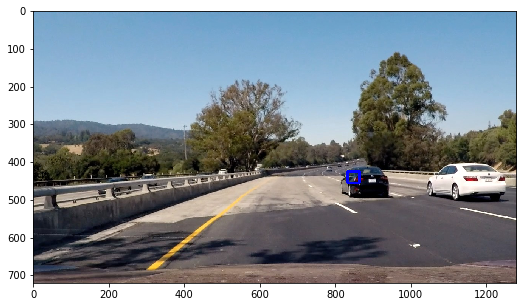

In [19]:
# read test images
test_images = readImages('test_images/*.jpg')

images = []

for test_image in test_images:
    # pipeline
    test_image_detected = imagePipeline(test_image)
    images.append(test_image_detected)
    
plotImage(images[3])

___
#### Code Cell ?: Video Pipeline
*Test of the Classifier with test video*<br>
**Input:** path of the test video<br>
**Output:** video with marked detected vehicles

In [20]:
def videoPipeline(img):
    # Sliding window
    res_img = imagePipeline(img)
    
    return res_img

#### Code Cell ?: Detect vehicles on video
**Input:** name of the test video<br>
**Output:** video with marked detected vehicles will be written in current folder

In [23]:
def detectVehicles(video_file_name):
    clip = VideoFileClip(video_file_name+'.mp4')
    #clip = VideoFileClip(video_file_name+'.mp4').subclip(15,16)
    video_clip = clip.fl_image(videoPipeline)
    %time video_clip.write_videofile(video_file_name+'_with_detected_vehicles.mp4', audio=False)

In [26]:
detectVehicles('project_video')

[MoviePy] >>>> Building video project_video_with_detected_vehicles.mp4
[MoviePy] Writing video project_video_with_detected_vehicles.mp4



  5%|████▎                                                                           | 67/1261 [01:10<20:51,  1.05s/it]


 11%|████████▍                                                                      | 135/1261 [02:21<19:23,  1.03s/it]


 16%|████████████▋                                                                  | 203/1261 [03:31<18:28,  1.05s/it]


 21%|████████████████▉                                                              | 271/1261 [04:42<17:29,  1.06s/it]


 27%|█████████████████████▏                                                         | 339/1261 [05:53<15:57,  1.04s/it]


 32%|█████████████████████████▍                                                     | 407/1261 [07:04<14:58,  1.05s/it]


 38%|█████████████████████████████▊                                                 | 475/1261 [08:17<15:38,  1.19s/it]


 43%|██████████████████████████████████                                             | 543/1261 [09:28<13:06,  1.10s/it]


 48%|██████████████████████████████████████▎                                        | 611/1261 [10:40<11:07,  1.03s/it]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [11:50<10:01,  1.03s/it]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [13:01<08:46,  1.02s/it]


 65%|███████████████████████████████████████████████████                            | 815/1261 [14:11<07:39,  1.03s/it]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [15:22<06:34,  1.04s/it]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [16:32<05:21,  1.04s/it]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [17:43<04:12,  1.04s/it]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [18:52<03:00,  1.04s/it]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [20:03<01:49,  1.04s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [21:14<00:39,  1.04s/it]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:56<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_detected_vehicles.mp4 

Wall time: 21min 57s
